In [12]:
#plot en jupyter
%matplotlib inline 
#Paquetes a usar 
import numpy as np 
import pandas as pd 
import pylab as pl 
import datetime as dt 
import os 
from wmf import wmf 
# import func_SIATA as fS
from multiprocessing import Pool
#Ignorar avisos pendejos
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
# para la funcion.
import pandas as pd 
import datetime as dt 
import numpy as np 

In [14]:
fechaI='2017-01-01-00:00:00'
fechaF='2017-12-31-23:55:00'
freq_='120Min'

In [29]:
def radiacion_teorica_escalada(fechaI, fechaF,freq_):
    rng=pd.date_range(fechaI, fechaF, freq=freq_)
    rad=np.zeros(rng.size)
    for pos,time in enumerate(rng):
        Hora=time
        # Dia del Año
        dn = Hora.timetuple().tm_yday
        Theta_d = (2 * np.pi * (dn-1))/ 365.
        # (d/d)2
        an = [1.000110, 0.034221, 0.000719]
        bn = [0,        0.001280, 0.000077]
        #
        d   = 0
        tmp = 0
        for i in range(3):
            tmp = (an[i] * np.cos(i*Theta_d)) + (bn[i] * np.sin(i*Theta_d))
            d = d + tmp
        # Delta
        a_n = [0.006918, -0.399912, -0.006758, -0.002697]
        b_n = [0,         0.070257,  0.000907,  0.001480]
        #
        Delta = 0
        tmp   = 0
        for i in range(4):
            tmp = (a_n[i] * np.cos(i*Theta_d)) + (b_n[i] * np.sin(i*Theta_d))
            Delta = Delta + tmp
        #Angulo horario (cada minuto)
        Minutos = (Hora.hour * 60) + Hora.minute
        Horario = 180 - (0.25 * Minutos)
        Horario = (Horario * np.pi)/180.
        # Coseno de Theta
        Latitud = (6.2593 * np.pi)/180.
        Cos_Theta = (np.sin(Latitud)*np.sin(Delta)) + (np.cos(Latitud)*np.cos(Delta)*np.cos(Horario))
        # Radiacion Teorica
        So = 1367 #w/m2
        Q = So * d * Cos_Theta
        # Escala entre 0 y 1
        rad_max=1369.8721876806876
        Q=1*Q/rad_max
        #Guarda
        rad[pos]=Q
    #Se vuelven cero los valores negativos.
    rad[rad<0]=0
    #Serie
    rad=pd.Series(rad,index=rng)
    return rad

In [30]:
fechaI='2016-01-01-00:00:00'
fechaF='2016-12-31-23:55:00'
freq_='120Min'
lol=radiacion_teorica_escalada(fechaI,fechaF,freq_)

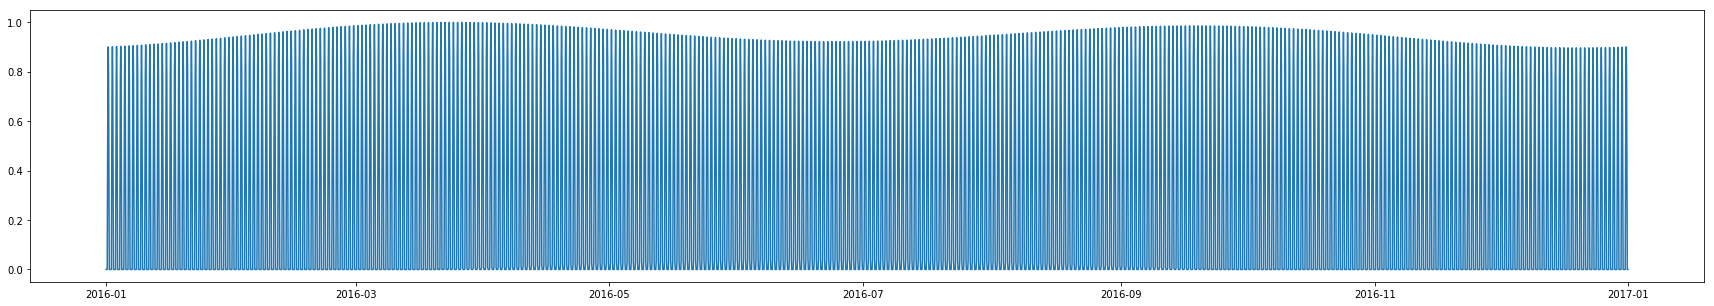

In [31]:
pl.figure(figsize=(30,5))
pl.plot(lol)

#### Se carga a informacion registrada en la cuenca

Radar

In [32]:
#Rutas
ruta_rain = '/media/nicolas/Home/nicolas/01_SIATA/bin_rain/Picacha/'
ruta_qobs = '/media/nicolas/Home/Jupyter/Soraya/series/Qobs116_1min_2014-07-10_2017-10-23.msg'
ruta_cuenca = '/media/nicolas/Home/nicolas/01_SIATA/nc_cuencas/Picacha_Abajo.nc'

In [33]:
year = {'2013':'Campos_Picacha_2013_300s',
        '2014':'Campos_Picacha_2014_300s',
        '2015':'Campos_Picacha_2015_300s',
        '2016':'Campos_Picacha_2016_300s',
        '2017':'Campos_Picacha_2017-01-01_2017-10-25_300s'}#,
        #'2017':'Campo_LaInmaculada12m_2017_300s_u0.01'}

In [34]:
Rain={}
Rain.update({'2013':wmf.read_mean_rain(ruta_rain+year['2013']+'.hdr')})
Rain.update({'2014':wmf.read_mean_rain(ruta_rain+year['2014']+'.hdr')})
Rain.update({'2015':wmf.read_mean_rain(ruta_rain+year['2015']+'.hdr')})
Rain.update({'2016':wmf.read_mean_rain(ruta_rain+year['2016']+'.hdr')})
Rain.update({'2017':wmf.read_mean_rain(ruta_rain+year['2017']+'.hdr')})

In [37]:
P=Rain['2013'].append(Rain['2014'])
P=P.append(Rain['2015'])
P=P.append(Rain['2016'])
P=P.append(Rain['2017'])
P=P.reindex(pd.date_range(P.index[0],P.index[-1],freq='5min'))

A falta de curva de calibración se usa **Nivel**

In [35]:
N = pd.read_msgpack(ruta_qobs)
N=N.resample('5min').mean()/100 # en metros

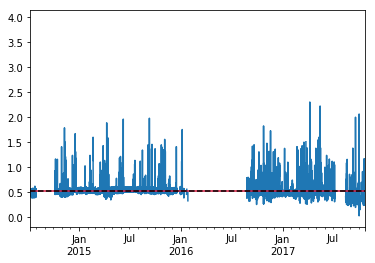

In [36]:
N.plot()
medianaN=np.percentile(N.dropna(),50)
media=N.mean()
pl.axhline(medianaN,c='crimson')
pl.axhline(media,c='k',ls='--')

Solo se analiza en el rango en que concuerden.

In [38]:
print N.index[0]
print N.index[-1]

2014-07-10 00:00:00
2017-10-23 18:25:00


In [39]:
print P.index[0]
print P.index[-1]

2012-12-31 19:05:00
2017-10-25 18:55:00


In [40]:
P=P[N.index[0]:P.index[-1]]

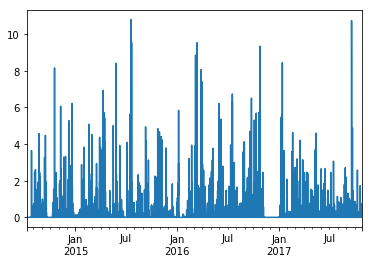

In [41]:
P.plot()

#### Se separan los eventos

Función

In [42]:
def FindMax(Q,fechas,umbral,horasAtras=12,BusquedaAdelante=36):
    '''Nota: Q debe ser un masked_array'''
    pos=np.where(Q>umbral)[0]
    grupos=[];g=[];Qmax=[]
    #Encuentra el maximo de cada grupo
    for pant,pnext in zip(pos[:-1],pos[1:]):        
        if pant+1>=pnext and pant+BusquedaAdelante>=pnext:
            g.append(pant)
        else:
            if len(g)>0:
                PosMaxGrupo=np.argmax(Q[g])
                grupos.append(g[PosMaxGrupo])
                Qmax.append(np.max(Q[g]))
            g=[]
    #Pule el maximo por si hay noData
    for c,g in enumerate(grupos):
        if Q.mask[g-1]:
            grupos.pop(c)
    #Obtiene las fechas 12 horas atras 
    if type(fechas)==list:
        fechas=__np.array(fechas)
    FechasAtras=fechas[grupos]-dt.timedelta(hours=horasAtras)
    fechas=list(fechas)     
    posAtras=[fechas.index(i) for i in FechasAtras]
    return grupos,np.array(Qmax)

El limite para buscar eventos importantes se escoge mirando los eventos en la serie

In [43]:
#Busqueda de maximos 
Nma = np.ma.array(N.values, mask=N.values > 3)
G, Nmax = FindMax(Nma, N.index.to_pydatetime(), 1, BusquedaAdelante=100)
#Maximos establecidos como series de pandas
Gs = pd.Series(Nma[G], index=N.index[G])
Gs.size

128

59

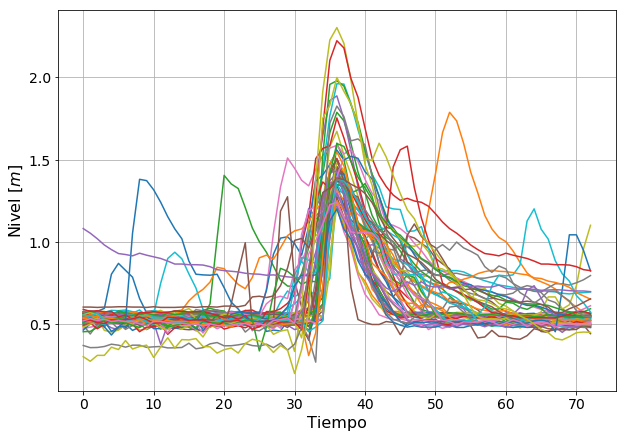

In [44]:
tm = pd.Timedelta('3 hours')
c = 0
fig = pl.figure(figsize=(10,7))
ax = fig.add_subplot(111)
Matriz = []
Pos = []
GsCut = []
for p,i in enumerate(Gs.index):
    #se guarda y plotea informacion solo para eventos importantes y con buena lluvia.
    if N[i] >= 1.2 and P[i-tm:i+tm].max() > 0: # - tm: i + tm].values.argmax()
        ax.plot(N[i - tm: i + tm].values)
        Matriz.append(N[i - tm: i + tm].values)
        c+=1
        Pos.append(p)
pl.grid()
pl.xlabel('Tiempo', size = 16)
pl.ylabel('Nivel $[m]$', size = 16)
ax.tick_params(labelsize = 14)
GsCut = Gs[Pos]
GsCut.size

In [45]:
eventos=np.random.randint(0,GsCut.size, 10)

#### Se prepara para simulación

--------------------> Nota: Hay que preparar la cuenca con las cosas de Slides!!!!! <--------------------------

In [49]:
cu = wmf.SimuBasin(rute=ruta_cuenca)
wmf.models.separate_fluxes = 1
wmf.models.show_storage = 1
wmf.models.dt = 300
wmf.models.retorno = 1
nodo=0

Maximo capilar

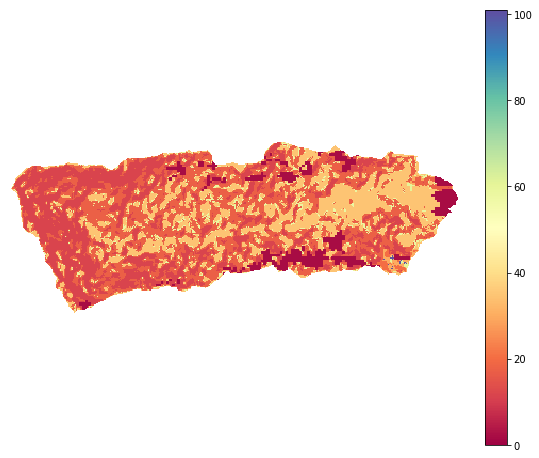

([-75.66084289550781,
  -75.613383493677247,
  6.223681449890137,
  6.2418729542769142],
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0b19280d90>)

In [47]:
cu.Plot_basinClean(wmf.models.max_capilar,show_cbar=True)

# Calibracion

In [547]:
index=GsCut.index[eventos[1]]
index

Timestamp('2017-02-23 22:50:00')

Correccion por desfase de nivel

In [548]:
corr=0

In [549]:
Inicio = P.index.get_loc(index-tm)+corr
Npasos = 80
Fin=Inicio+Npasos

Evento

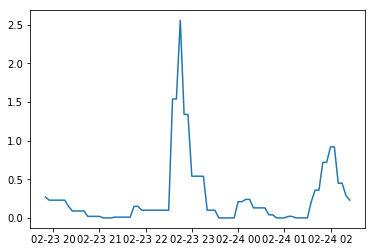

In [551]:
pl.plot(P[Inicio:Fin])

80

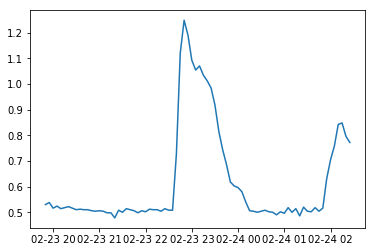

In [550]:
pl.plot(N[Inicio:Fin])
Npasos

Set de condiciones iniciales:

cu.set_Storage(wmf.models.max_capilar*0.8, 0)
cu.set_Storage(0.1, 1)
cu.set_Storage(0.1, 2)
cu.set_Storage(10,3)
cu.set_Storage(0.1, 4)

cu.set_Storage(wmf.models.max_capilar*0.8, 0)
cu.set_Storage(0.1, 1)
cu.set_Storage(0.1, 2)
cu.set_Storage(0.1,3)
cu.set_Storage(0.1, 4)

cu.set_Storage(wmf.models.max_capilar*0.5, 0)
cu.set_Storage(0.1, 1)
cu.set_Storage(5, 2)
cu.set_Storage(0,3)
cu.set_Storage(0.1, 4)


cu.set_Storage(wmf.models.max_capilar*0.8, 0)
cu.set_Storage(0.1, 1)
cu.set_Storage(10, 2)
cu.set_Storage(50,3)
cu.set_Storage(0.1, 4)


In [552]:
cu.set_Storage(wmf.models.max_capilar*0.8, 0)
cu.set_Storage(0.1, 1)
cu.set_Storage(1, 2)
cu.set_Storage(50,3)
cu.set_Storage(0.1, 4)


Ejecución 1

In [568]:
corr=0
inicio=Rain[str(index.year)].index.get_loc(index-tm)+corr
Calib = [0.000034, 28, 15, 0, 8, 6, 1, 0.89999, 1.3, 1] # -- para picos.
Calib = [0.000034, 80, 15, 0, 1, 6, 1, 0.89999, 3, 1]
# Calib = [0.000034, 225, 40, 0, 0.008, 6, 1, 0.89999, 3, 1]
Res = cu.run_shia(Calib, ruta_rain+year[str(index.year)]+'.bin', Npasos, inicio)#,kinematicN=7)

Se arman las series a plotear, obviando los primeros 20 pasos de calentamiento

In [569]:
ini=20;end=Npasos;corr=0
Qsim=Res[0]['Qsim'][nodo][ini:end]
Qrun = Res[0]['Fluxes'][nodo][0][ini:end]
Qsub = Res[0]['Fluxes'][nodo][1][ini:end]
Qbase = Qsim - Qrun - Qsub
Qsim2=Qsim-0.25+medianaN #se cambia la magnitud del valor.
Qsep = np.vstack([Qsim,Qsim2, Qrun+Qbase, Qsub+Qbase, Qbase])
Qobs=N[Inicio+corr:Fin+corr][ini:end]
S=P[Inicio:Fin][ini:end]
NS=wmf.__eval_nash__(Qobs,Qsim2)
Mean_Storage=np.array([i[ini:end] for i in Res[0]['Mean_Storage']])

Plot

In [53]:
wmf.plot_sim_single(Qsep, 
    mrain=S.values, 
    Qo=Qobs.values)#,
#     Dates = Rain[index-tm:index+tm].index.to_pydatetime())
print 'Nash: '+NS

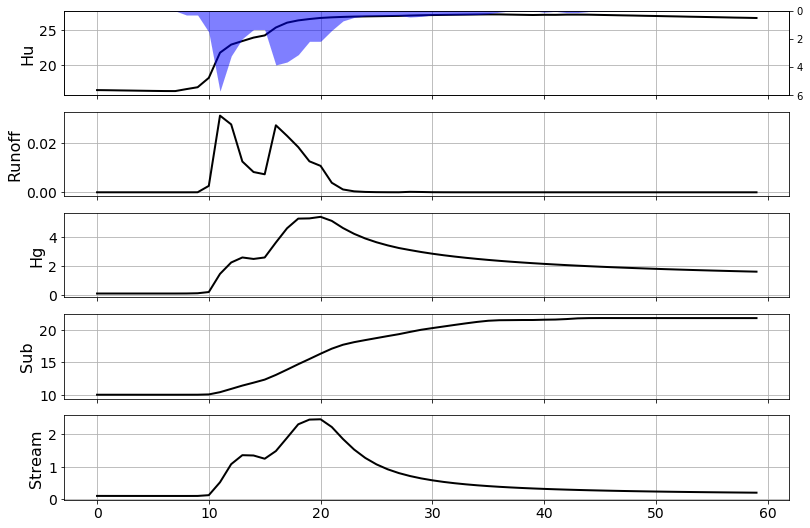

In [534]:
wmf.plot_mean_storage(Mean_Storage, mrain=S.values, lw = 2)

Evaporacion en los ultimos 40 pasos que deben estar alrededor de 0.4 

In [545]:
ini=Npasos-40;end=Npasos
Mean_Storage=np.array([i[ini:end] for i in Res[0]['Mean_Storage']])
Mean_Storage[0].max()-Mean_Storage[0][-1]

0.51480865

Acumulado de lluvia del evento

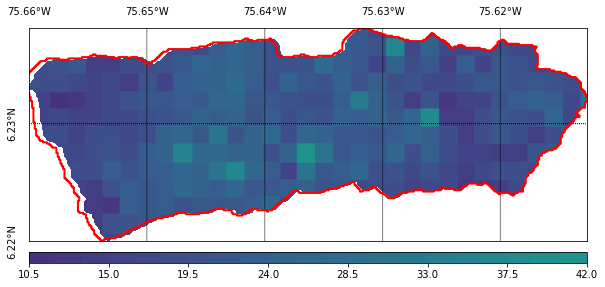

(<mpl_toolkits.basemap.Basemap at 0x7efb6db526d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efb6f987e50>)

In [571]:
cu.Plot_basin(Res[0]['Rain_Acum'],lines_spaces=0.01,vmin=0,vmax=80)

___